# Model

## Techniques
* Keras
* Data Augmentation
* Bottleneck Feature


## Problem
Image Classification <br/>
    * Macroinvertebrates
        * Identify 7 families of macroinvertebrates


## Calling Inception-v3 with ImageNet weigths.

In [2]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

from random import shuffle
from PIL import Image
import os
import numpy as np
import pickle

# Logging settings
import logging
import sys
logging.basicConfig(filename='report.log', format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout

# Default dimension 299x299
DIM = 299
CLASSES = 2

In [3]:
# InceptionV3 model with imagenet weights, no top and not trainable setting
base_model = InceptionV3(input_shape=(DIM, DIM, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

# Adding extra top layers

# In this case we use GlobalAveragePooling2D instead of flatten for complexity reduction
# Convert model output -> batchx8x8x2048 into batchx2048
# With flatten it'll be 64 times bigger

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(CLASSES, activation='softmax')(x)


# Concatenating model with our custom top
model = Model(base_model.input, predictions)
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Basic Data Loading Module

In [4]:
class LocalDataLoader:
    
    def __init__(self, img_dim, raw_dir = './data/', dset_dir = './dataset/', nb_per_class=20, val_ratio=0.3, test_ratio=0.1):
        self.raw_dir = raw_dir
        self.dset_dir = dset_dir
        self.img_dim = img_dim
        self.img_dim_str = '{}x{}'.format(img_dim[0], img_dim[1])
        self.nb_per_class = nb_per_class
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        
        self.dataset_name = '{}_{}'.format(self.nb_per_class, self.img_dim_str)
        
    def load_data(self):
        train_file_dir = "{}train_X_{}.p".format(self.dset_dir, self.dataset_name)
        if not os.path.isfile(train_file_dir):
            print("Dataset not found.")
            print("Creating dataset ...")
            self.create_dataset()
        else:
            print("Using existing dataset.")
        
        train_X = pickle.load(open("{}train_X_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        train_y = pickle.load(open("{}train_y_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        validation_X = pickle.load(open("{}validation_X_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        validation_y = pickle.load(open("{}validation_y_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        print("Dataset loaded!")
        return train_X, train_y, validation_X, validation_y
        
    def create_dataset(self):
        data = []
        class_names = os.listdir(self.raw_dir)
        
        for i, class_name in enumerate(class_names):
            class_dir = self.raw_dir + class_name + '/'
            
            files = os.listdir(class_dir)
            
            # Important to shuffle the files on the directory
            shuffle(files)
            files = files[:self.nb_per_class]
            
            print(class_name)
            for j, file in enumerate(files):
                file_dir = class_dir + file
                
                if j%50 == 0:
                    print("Processing file {} of {}".format(j, len(files)))
                
                try:
                    img = Image.open(file_dir)
                except:
                    print("Unable to open {} ... skipping file.".format(file))
                    pass
                
                img = img.convert('RGB')
                img = img.resize(self.img_dim, resample=Image.ANTIALIAS)
                imgData = np.asarray(img, dtype=np.uint8)
                imgData = imgData / 255.
        
                # One-hot encoded labels. ex:[0,0,1,0,0]
                label = [0 for class_name in range(len(class_names))]
                label[i] = 1
                data.append((imgData, label))
            print("--------------------------------------------------------------------")
        
        # Shuffle the data with all the classes
        shuffle(data)

        x, y = zip(*data)
        
        # Split data flags
        validation_nb = int(len(x) * self.val_ratio)
        test_nb = int(len(x) * self.test_ratio)
        train_nb = len(x) - (validation_nb + test_nb)
        
        # Splitting the data
        reshape_dim = [-1, self.img_dim[0], self.img_dim[1], 3]
        
        train_X = np.array(x[:train_nb]).reshape(reshape_dim)
        train_y = np.array(y[:train_nb])
        
        validation_X = np.array(x[train_nb:train_nb + validation_nb]).reshape(reshape_dim)
        validation_y = np.array(y[train_nb:train_nb + validation_nb])
        
        test_X = np.array(x[-test_nb:]).reshape(reshape_dim)
        test_y = np.array(y[-test_nb:])
        
        print("Dataset created!")
        
        # Create path for dataset if not existing
        if not os.path.exists(os.path.dirname(self.dset_dir)):
            try:
                os.makedirs(os.path.dirname(self.dset_dir))
            except OSError as exc:  # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

        # SaveDataset
        print("Saving dataset... ")
        pickle.dump(train_X, open("{}train_X_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        pickle.dump(train_y, open("{}train_y_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        pickle.dump(validation_X, open("{}validation_X_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        pickle.dump(validation_y, open("{}validation_y_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        pickle.dump(test_X, open("{}test_X_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        pickle.dump(test_y, open("{}test_y_{}.p".format(self.dset_dir, self.dataset_name), "wb"))
        print("Dataset saved!")
        
    
#loader = LocalDataLoader(img_dim=(DIM, DIM))
#data = loader.load_data()

## zca V2.0

Using existing dataset.
Dataset loaded!


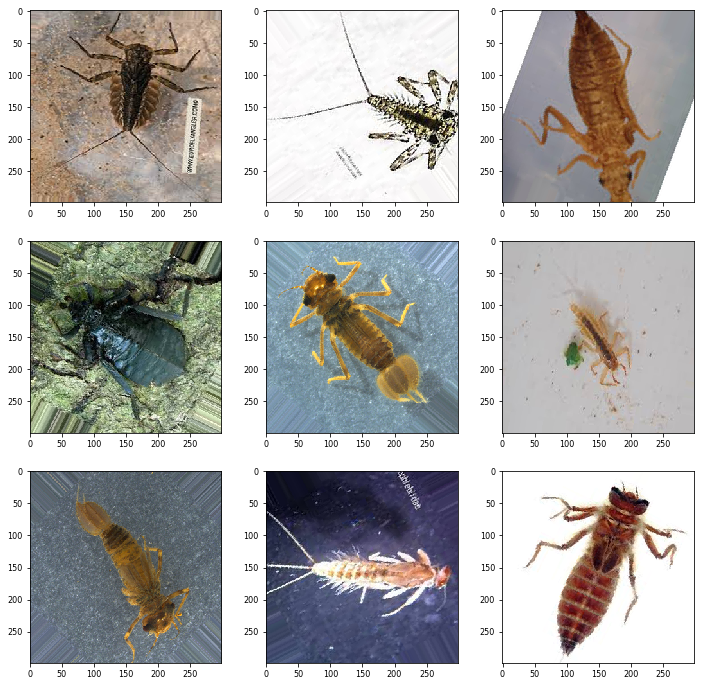

In [198]:
# ZCA whitening
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

#from keras import backend as K
#K.set_image_dim_ordering('th')


# load data
DIM=299
CHANNELS = 3

loader = LocalDataLoader(img_dim=(DIM, DIM))
X_train, y_train, X_test, y_test = loader.load_data()
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], DIM, DIM, CHANNELS)
X_test = X_test.reshape(X_test.shape[0], DIM, DIM, CHANNELS)

# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


# define data preparation
datagen = ImageDataGenerator(  
    rotation_range=90,
    vertical_flip=True
)

# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
    # create a grid of 3x3 images
    pyplot.figure(figsize=(12, 12))
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
        
    # show the plot
    pyplot.show()
    break

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

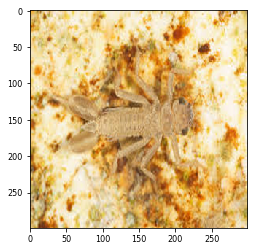

/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


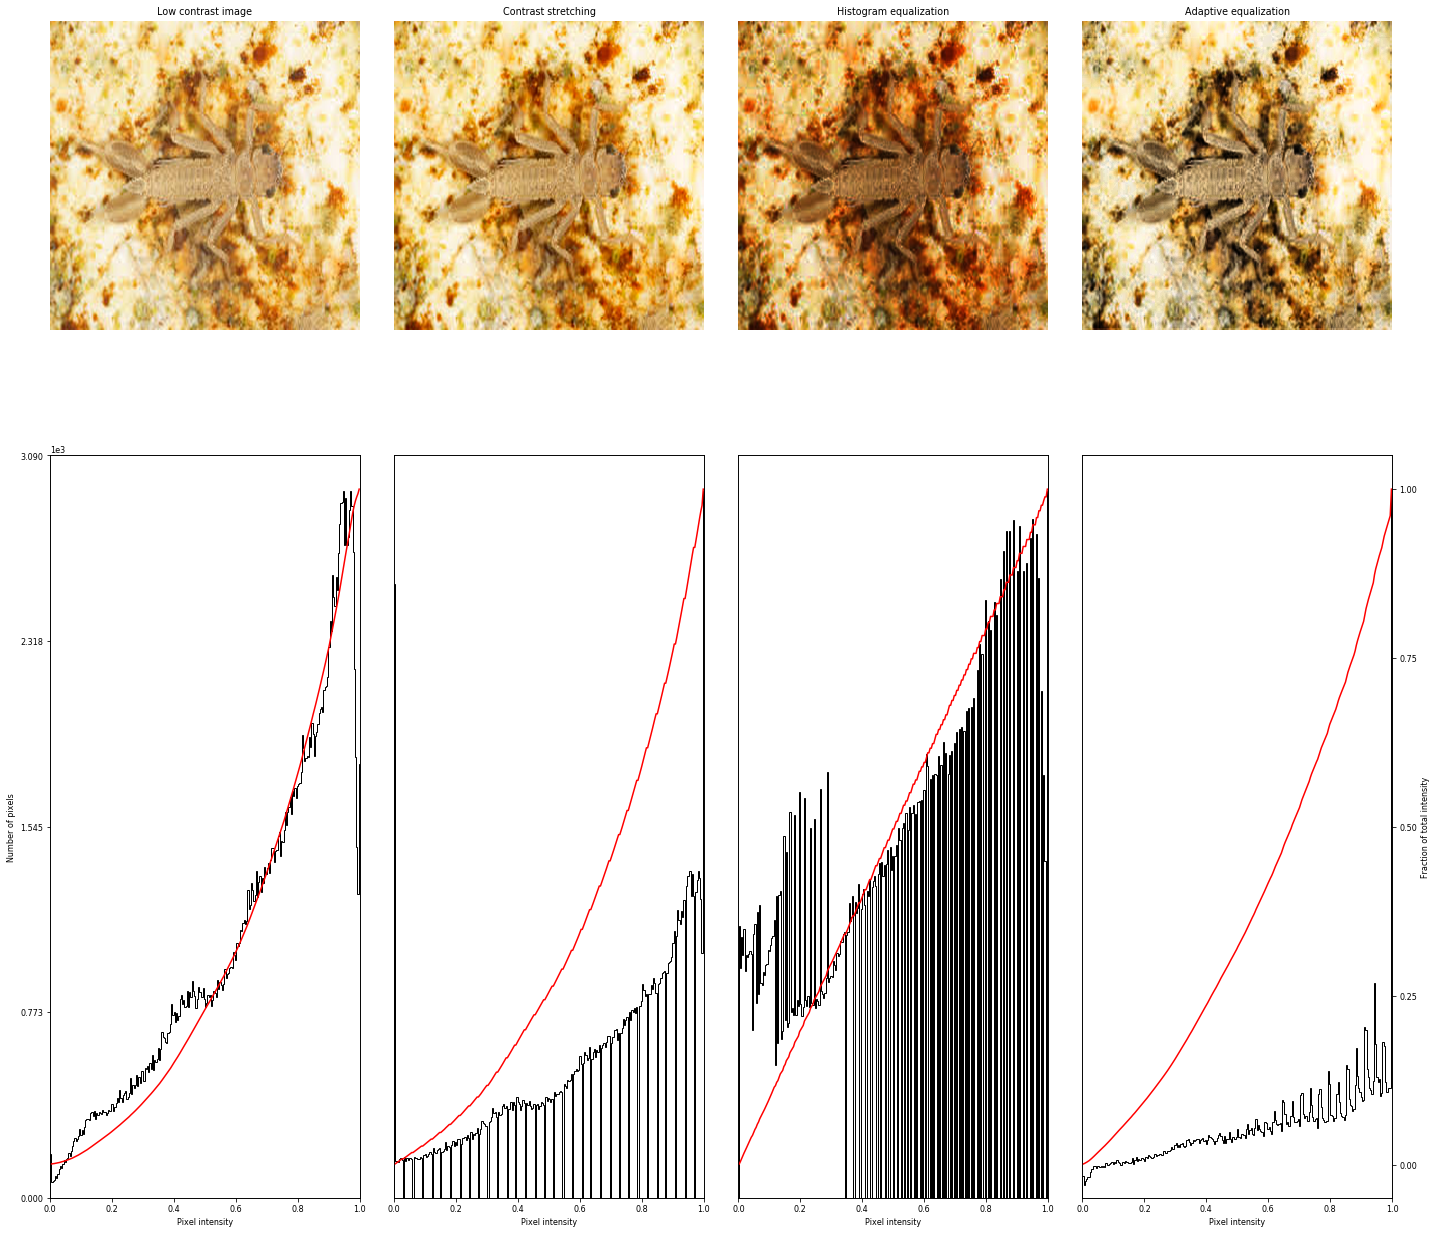

In [242]:
img = X_train[3]

pyplot.figure(figsize=(4, 4))
pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
        
# show the plot
pyplot.show()

# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

# Set font size for images
pyplot.rcParams['font.size'] = 8

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Histogram Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# img bright
illumin_limit = 0.7
alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
img_bright = np.clip(img * alpha, 0., 1.)

# img contrast
coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
gray = img * coef
gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
img_contrast = img * alpha + gray
img_contrast = np.clip(img_contrast,0.,1.)


# img saturation
coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
gray = img * coef
gray = np.sum(gray, axis=2, keepdims=True)
gray *= (1.0 - alpha)
img_saturation = img * alpha + gray
img_saturation = np.clip(img_saturation,0.,1.)



# adaptive equalization
x = img_as_float(img)
img_hsv = color.rgb2hsv(x)
brightness = img_hsv[:,:,2]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    b_adapteq = exposure.equalize_adapthist(
        brightness,
        clip_limit=0.03,
        nbins=48)

img_hsv[:,:,2] = b_adapteq
img_adapteq = color.hsv2rgb(img_hsv)


#### Everything below here is just to create the plot/graphs ####

# Display results
fig = pyplot.figure(figsize=(20, 20)) 
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
class FunctionArgs():
    def __init__(self, fun, *args):
        self.fun = fun
        self.args = args


Custom ImageDataGenerator
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>
<function histogram_equalization at 0x7fe1f7e20950>


/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


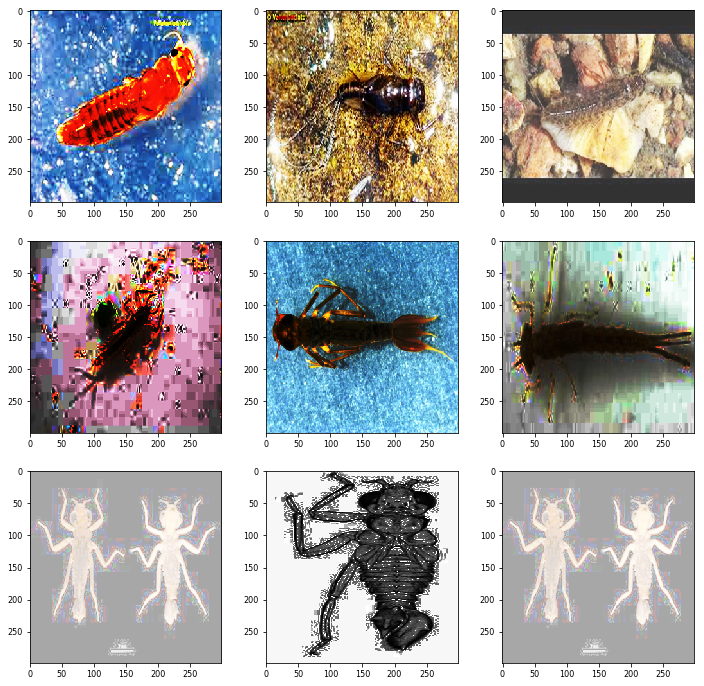

In [245]:
from skimage import data, img_as_float
from skimage import exposure, color, filters

import warnings


class ImageDataGenerator_dev(ImageDataGenerator):
    def __init__(self,
        custom_std_functions=0,
        custom_rdm_functions=0,
        *args, **kwargs):
        
        print('Custom ImageDataGenerator')
        super(ImageDataGenerator_dev, self).__init__(*args, **kwargs)
        self.custom_std_functions=custom_std_functions
        self.custom_rdm_functions=custom_rdm_functions
      
    def standardize(self, *args, **kwargs):
        x = super(ImageDataGenerator_dev, self).standardize(*args, **kwargs)
        if self.custom_std_functions:
            for task in self.custom_std_functions:
                print(task.fun)
                x = task.fun(x, *task.args)
        return x
        
        
    def random_transform(self, 
        *args, **kwargs):
        x = super(ImageDataGenerator_dev, self).random_transform(*args, **kwargs)
        if self.custom_rdm_functions:
            for task in self.custom_rdm_functions:
                x = task.fun(x, *task.args)
        return x
    
def blurring(x, min_blur=0, max_blur=0):
    b =  np.random.uniform(min_blur, max_blur)
    if np.shape(x)[2] == 1:
        x = filters.gaussian(x, sigma=b, multichannel = None)

    elif np.shape(x)[2] == 3:
        x = filters.gaussian(x, sigma=b, multichannel = False)

    else:
        warnings.warn('Improper Image Size - Expected Format - ?,?,1 or 3')
        
    return x

def adaptive_equalization(x, limit = 0.03):
    if np.shape(x)[2] == 1:
        x = exposure.equalize_adapthist(x, clip_limit=limit, nbins=48)

    elif np.shape(x)[2] == 3:
        x = img_as_float(x)
        img_hsv = color.rgb2hsv(x)
        brightness = img_hsv[:,:,2]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            b_adapteq = exposure.equalize_adapthist(
                brightness,
                clip_limit=limit,
                nbins=48)

        img_hsv[:,:,2] = b_adapteq
        x = color.hsv2rgb(img_hsv)

    else:
        warnings.warn('Improper Image Size - Expected Format - ?,?,1 or 3') 
    
    return x

def contrast_stretching(x, p_ini = 2, p_fin = 98):
    pi, pf = np.percentile(x, (p_ini, p_fin))
    x = exposure.rescale_intensity(x, in_range=(pi, pf))
    return x

def histogram_equalization(x, *args):
    x = exposure.equalize_hist(x)
    return x

# img bright
def random_bright(x, alpha=None, illum_limit = 0.7):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
    
    img_bright = np.clip(x * alpha, 0., 1.)
    return img_bright

def random_contrast(x, alpha=None, illum_limit=0.7):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
        
    coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B
    gray = x * coef
    gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
    
    img_contrast = x * alpha + gray
    img_contrast = np.clip(img_contrast,0.,1.)
    return img_contrast


def random_saturation(x, alpha=None, illum_limit=0.7):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
        
    coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B
    gray = x * coef
    gray = np.sum(gray, axis=2, keepdims=True)
    gray *= (1.0 - alpha)
    
    img_saturation = x * alpha + gray
    img_saturation = np.clip(img_saturation,0.,1.)
    return img_saturation


    
class Task:
    def __init__(self, fun, *args):
        self.fun = fun
        self.args = args

# define data preparation
datagen = ImageDataGenerator_dev(  
    custom_rdm_functions=[
        #Task(blurring, 1, 3),
    ],
    custom_std_functions=[
        #Task(contrast_stretching, 2, 98),
        Task(histogram_equalization),
        #Task(adaptive_equalization, 0.03)
        
    ]
)


# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    pyplot.figure(figsize=(12, 12))
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
        
    # show the plot
    pyplot.show()
    break


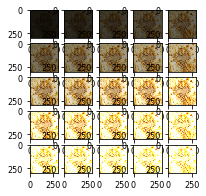

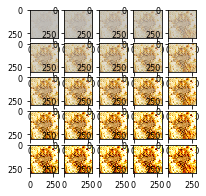

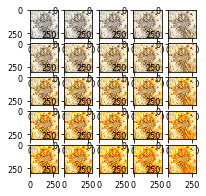

In [260]:
image = img
pyplot.figure(figsize=(3, 3))

for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(random_bright(image, 0.1 + 1.9/25*i), cmap=pyplot.get_cmap('gray'))

# show the plot
#pyplot.show()


pyplot.figure(figsize=(3, 3))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(random_contrast(image, 0.1 + 1.9/25*i), cmap=pyplot.get_cmap('gray'))

# show the plot
#pyplot.show()


pyplot.figure(figsize=(3, 3))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(random_saturation(image, 0.1 + 1.9/25*i), cmap=pyplot.get_cmap('gray'))

# show the plot
pyplot.show()

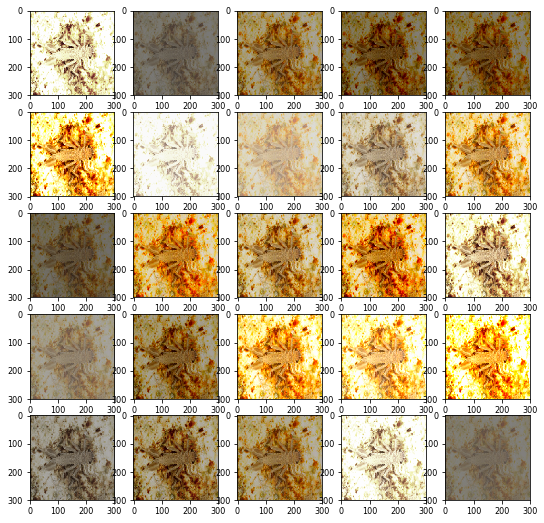

In [266]:
image = img
pyplot.figure(figsize=(9, 9))

for i in range(25):
    pyplot.subplot(5,5,i+1)
    x = random_bright(image)
    x = random_contrast(x)
    x = random_saturation(x)
    pyplot.imshow(x, cmap=pyplot.get_cmap('gray'))

# show the plot
pyplot.show()

In [211]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(DIM, DIM),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(DIM, DIM),
        batch_size=batch_size,
        class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

In [10]:
model.compile(optimizer='nadam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


In [11]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()


Epoch 1/10
32/32 [==============================] - 312s - loss: 0.6146 - acc: 0.6797 - val_loss: 0.5898 - val_acc: 0.7247
Epoch 2/10
32/32 [==============================] - 308s - loss: 0.4443 - acc: 0.8340 - val_loss: 0.3414 - val_acc: 0.8244
Epoch 3/10
32/32 [==============================] - 307s - loss: 0.3343 - acc: 0.8574 - val_loss: 0.3239 - val_acc: 0.8259
Epoch 4/10
32/32 [==============================] - 310s - loss: 0.2441 - acc: 0.9219 - val_loss: 0.5717 - val_acc: 0.8006
Epoch 5/10
32/32 [==============================] - 345s - loss: 0.2692 - acc: 0.9043 - val_loss: 0.2881 - val_acc: 0.9003
Epoch 6/10
32/32 [==============================] - 338s - loss: 0.2324 - acc: 0.9180 - val_loss: 0.6308 - val_acc: 0.7991
Epoch 7/10
32/32 [==============================] - 323s - loss: 0.1980 - acc: 0.9297 - val_loss: 0.4647 - val_acc: 0.7991
Epoch 8/10
32/32 [==============================] - 312s - loss: 0.2277 - acc: 0.9199 - val_loss: 0.1833 - val_acc: 0.9494
Epoch 9/10
32/32

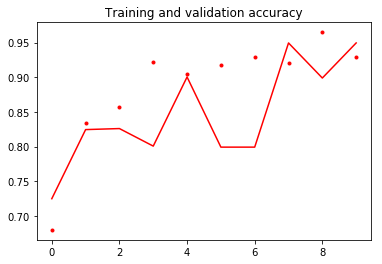

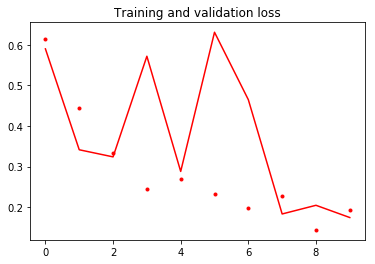

In [6]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from datetime import datetime
now = datetime.now()
logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True)

model_path = './models'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
    tbCallBack,    
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)       
]


history_ft = model.fit_generator(
        train_generator,
        #steps_per_epoch=2000 // batch_size,
        steps_per_epoch=16*2,
        epochs=10,
        validation_data=validation_generator,
        #validation_steps=800 // batch_size,
        validation_steps=50,
        callbacks = callbacks_list)

plot_training(history_ft)


Epoch 1/10
32/32 [==============================] - 344s - loss: 0.0792 - acc: 0.9863 - val_loss: 0.2136 - val_acc: 0.8988
Epoch 2/10
32/32 [==============================] - 336s - loss: 0.0777 - acc: 0.9883 - val_loss: 0.2196 - val_acc: 0.8988
Epoch 3/10
32/32 [==============================] - 336s - loss: 0.0693 - acc: 0.9844 - val_loss: 0.2101 - val_acc: 0.8988
Epoch 4/10
32/32 [==============================] - 365s - loss: 0.0726 - acc: 0.9883 - val_loss: 0.2062 - val_acc: 0.9003
Epoch 5/10
32/32 [==============================] - 355s - loss: 0.0825 - acc: 0.9746 - val_loss: 0.2130 - val_acc: 0.8988
Epoch 6/10
32/32 [==============================] - 363s - loss: 0.0737 - acc: 0.9863 - val_loss: 0.1845 - val_acc: 0.9018
Epoch 7/10
32/32 [==============================] - 361s - loss: 0.0977 - acc: 0.9707 - val_loss: 0.1758 - val_acc: 0.9241
Epoch 8/10
32/32 [==============================] - 360s - loss: 0.0564 - acc: 0.9883 - val_loss: 0.1812 - val_acc: 0.8988
Epoch 9/10
32/32

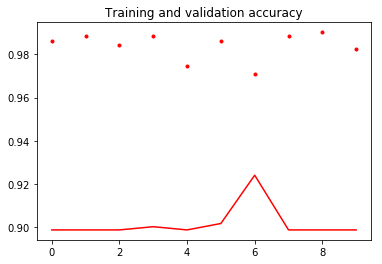

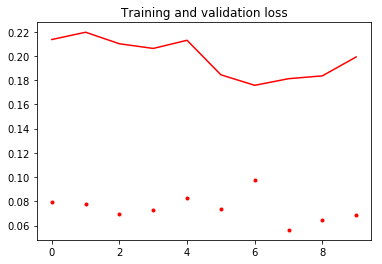

In [9]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from datetime import datetime
now = datetime.now()
logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True)

model_path = './models'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
    tbCallBack,    
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0)       
]

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_ft = model.fit_generator(
        train_generator,
        #steps_per_epoch=2000 // batch_size,
        steps_per_epoch=16*2,
        epochs=10,
        validation_data=validation_generator,
        #validation_steps=800 // batch_size,
        validation_steps=50,
        callbacks = callbacks_list)

plot_training(history_ft)

In [10]:
model.load_weights('./models/top_model_weights.h5')
model.evaluate_generator(validation_generator, 40)

[0.17488652542789482, 0.92537313432835822]

In [12]:
from keras.preprocessing import image
import numpy as np

label_map = ['Calopterygidae', 'Heptageniidae']


img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Calopterygidae/DMS10089.JPG',
#img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Heptageniidae/DMS10132.JPG',
                    target_size=(DIM,DIM))
x = image.img_to_array(img)
x /=255
x = np.expand_dims(x, axis=0)


images = np.vstack([x])

classes = model.predict(images)
print(label_map)
print(classes)


['Calopterygidae', 'Heptageniidae']
[[ 0.82819688  0.17180313]]


In [13]:
# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(DIM, DIM),
        batch_size=batch_size,
        class_mode='categorical')

model.evaluate_generator(test_generator, 34)


Found 34 images belonging to 2 classes.


[0.29425117471852363, 0.88205128205128203]